#### About Author
` +++  https://github.com/rashidrao-pk/anomaly_detection_trust_case_study`<br>
` +++  Author : Muhammad Rashid`<br>
` +++  PhD Student, University of Turin, Italy`<br>
` +++  This code is written for article, 'Can I trust my anomaly detection system? A case study'`<br>
` +++  Please Cite us if you use this code`<br>
` +++  thanks`<br>

## Import Libraries

In [1]:
from IPython.display import clear_output
import logging
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
logging.getLogger('matplotlib').setLevel(level=logging.CRITICAL)
logging.getLogger('tensorflow').setLevel(level=logging.FATAL)

In [2]:
import time
import numpy as np
import utils as ut
import models as mdl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter
from skimage.segmentation import mark_boundaries
from matplotlib.colors import BoundaryNorm, ListedColormap
import random,sys,importlib,keras,os,cv2,time,string,sklearn
pd.set_option('display.max_rows', 500)

print(f"Tensorflow \t\t:\t{tf.__version__}")
use_tfp= True
if use_tfp:
    import tensorflow_probability as tfp
    print(f"TensorflowProb \t\t:\t{tfp.__version__}")
print(f"Python \t\t\t:\t{sys.version}")
print(f"Pandas \t\t\t:\t{pd.__version__}")
print(f"Numpy \t\t\t:\t{np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print(f'GPU Usage\t\t:\t{gpu}')
if gpu:
    tf.tpu.XLAOptions(
    use_spmd_for_xla_partitioning=True, enable_xla_dynamic_padder=True)


Tensorflow 		:	2.15.0


TensorflowProb 		:	0.23.0
Python 			:	3.10.0 | packaged by conda-forge | (default, Nov 10 2021, 13:20:59) [MSC v.1916 64 bit (AMD64)]
Pandas 			:	2.2.0
Numpy 			:	1.26.3
GPU Usage		:	False


## Load Data

In [3]:
if os.name=='LINUX':
    DS_path_os = os.path.abspath('/media/rashid/Datasets/')
else:
    DS_path_os = os.path.abspath('D:')
    
DS_path_main = os.path.join(DS_path_os,'DS/AD/mvtec_anomaly_detection')
DS_path_main
DS_name = 'screw'
DS_path = os.path.join(DS_path_main,DS_name)
train_dir,gtruth_dir,test_dir = ut.Data.get_subdata(DS_path=DS_path)

In [4]:
##################   GENERAL CONFIGURATION     ##################
dpi=150

In [5]:
importlib.reload(ut)   
codes_path = os.getcwd()
results_path=os.path.join(codes_path,'results')
ut.Data.path_verifier(path=results_path)
results_path = os.path.join(results_path,DS_name)
ut.Data.path_verifier(path=results_path)
models_main_path=os.path.abspath(os.path.join(codes_path,'models'))
ut.Data.path_verifier(path=models_main_path)

C:\Users\XN2\anomaly_detection_trust_case_study\results already
C:\Users\XN2\anomaly_detection_trust_case_study\results\screw already
C:\Users\XN2\anomaly_detection_trust_case_study\models already


In [6]:
importlib.reload(ut)   
anomaly_types = sorted(os.listdir(test_dir))
anomaly_types_gt = sorted(os.listdir(gtruth_dir))

anomaly_types,anomaly_types_gt = ut.Data.get_anomaly_types(test_dir=test_dir,
                                                           dataset=DS_name,
                                                           gt_dir=gtruth_dir)
image_counter_cls = []
for i in range(len(anomaly_types)):
    image_counter_cls.extend([[anomaly_types[i],len(os.listdir(os.path.join(test_dir,anomaly_types[i])))]])

************************************************************************************************************************
Classes in Test:	['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']
Classes in GT:		['manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']
************************************************************************************************************************
Classes in Test:	['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [7]:
# Loading Normal and Anamolous Data
importlib.reload(ut)

ds   = ut.Data.load_data_normal(DS_path=f'{train_dir}', batch_size=image_counter_cls[0][1])
print('************ Loading test data ************')
ds_a0 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[0]}', batch_size=image_counter_cls[0][1])
ds_a1 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[1]}', batch_size=image_counter_cls[1][1])
ds_a2 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[2]}', batch_size=image_counter_cls[2][1])
ds_a3 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[3]}', batch_size=image_counter_cls[3][1])
ds_a4 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[4]}', batch_size=image_counter_cls[4][1])
ds_a5 = ut.Data.load_data_abnormal(DS_path=f'{test_dir}/{anomaly_types[5]}', batch_size=image_counter_cls[5][1])
print('************ Loading GTruth ************')
gt_a1 = ut.Data.load_data_gtruth(DS_path=f'{gtruth_dir}/{anomaly_types[1]}', batch_size=image_counter_cls[1][1])
gt_a2 = ut.Data.load_data_gtruth(DS_path=f'{gtruth_dir}/{anomaly_types[2]}', batch_size=image_counter_cls[2][1])
gt_a3 = ut.Data.load_data_gtruth(DS_path=f'{gtruth_dir}/{anomaly_types[3]}', batch_size=image_counter_cls[3][1])
gt_a4 = ut.Data.load_data_gtruth(DS_path=f'{gtruth_dir}/{anomaly_types[4]}', batch_size=image_counter_cls[4][1])
gt_a5 = ut.Data.load_data_gtruth(DS_path=f'{gtruth_dir}/{anomaly_types[5]}', batch_size=image_counter_cls[5][1])

# a_type=   anomaly_types[5]
ds_a = [ds_a0,ds_a1,ds_a2,ds_a3,ds_a4,ds_a5]
gt_a = [ds_a0,gt_a1,gt_a2,gt_a3,gt_a4,gt_a5]


Found 320 files belonging to 1 classes.
************ Loading test data ************
Found 41 files belonging to 1 classes.
Found 24 files belonging to 1 classes.
Found 24 files belonging to 1 classes.
Found 25 files belonging to 1 classes.
Found 23 files belonging to 1 classes.
Found 23 files belonging to 1 classes.
************ Loading GTruth ************
Found 24 files belonging to 1 classes.
Found 24 files belonging to 1 classes.
Found 25 files belonging to 1 classes.
Found 23 files belonging to 1 classes.
Found 23 files belonging to 1 classes.


In [8]:
importlib.reload(ut)
importlib.reload(mdl)
augmentation_target = 'custom' # 'medium', 'full' minimal , custom
train_generator,test_generator, gtruth_generator= ut.Data2.load_data(train_dir = train_dir,
                                                                     test_dir = test_dir,
                                                                     gtruth_dir = gtruth_dir,
                                                                     dataset=DS_name,
                                                                     classes = anomaly_types,
                                                                     augmentation_target=augmentation_target,
                                                                    )

Found 320 images belonging to 1 classes.
Found 160 images belonging to 6 classes.
Found 119 images belonging to 5 classes.


In [9]:
image_counter = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in test_generator.class_indices}
print(image_counter)

min_image_count = min(image_counter.items(), key=lambda x: x[1])[1]
min_image_class = min(image_counter.items(), key=lambda x: x[1])[0]
print(min_image_class,min_image_count)
from collections import Counter
Counter(test_generator.classes)
lbls_cls = list(image_counter.keys())
count_cls = list(image_counter.values())
lbls_cls,count_cls

{'good': 41, 'manipulated_front': 24, 'scratch_head': 24, 'scratch_neck': 25, 'thread_side': 23, 'thread_top': 23}
thread_side 23


(['good',
  'manipulated_front',
  'scratch_head',
  'scratch_neck',
  'thread_side',
  'thread_top'],
 [41, 24, 24, 25, 23, 23])

### VAE_GAN Model

In [10]:
image_size=[128, 128]
latent_dim=32

In [11]:
importlib.reload(ut)
importlib.reload(mdl)
num_epochs = 10000
latent_dim = 32
model_type = ['VAE_GAN']
mdl_type = model_type[0]
ittl = f'vae_{mdl_type}'

def build_model(image_size, latent_dim):
    encoder = mdl.Model_VAE_GAN_functions.get_encoder(latent_dim=latent_dim, print_summary=False)
    decoder = mdl.Model_VAE_GAN_functions.get_decoder(latent_dim=latent_dim, print_summary=False)
    discriminator = mdl.Model_VAE_GAN_functions.get_discriminator(shape=image_size + [3], print_summary=False)
    vae = mdl.VAE(encoder, decoder)
    model = mdl.VAE_GAN(vae, discriminator)
    return model
def save_model(model, prefix):
    model.save_weights(prefix+'_model', save_format='tf')
    model.vae.save_weights(prefix+'_vae', save_format='tf')
    model.vae.encoder.save_weights(prefix+'_encoder', save_format='tf')
    model.vae.decoder.save_weights(prefix+'_decoder', save_format='tf')
    model.discriminator.save_weights(prefix+'_discriminator', save_format='tf')
    print('Model saved.')
def load_model(model, prefix):
    model.load_weights(prefix+'_model')
    model.vae.load_weights(prefix+'_vae')
    model.vae.encoder.load_weights(prefix+'_encoder')
    model.vae.decoder.load_weights(prefix+'_decoder')
    model.discriminator.load_weights(prefix+'_discriminator')
    # print('Model loaded.')

In [12]:
num_epochs = 30000
models_path = os.path.abspath(f'{models_main_path}/{DS_name}_VAE_GAN_{num_epochs}')
print('Model Path:',models_path)
model = build_model(image_size, latent_dim)
model.compile(optimizer=tf.keras.optimizers.Adam())
history_frame = pd.DataFrame(columns=['vae_loss', 'disc_loss', 'gen_los'])
prefix_fname = models_path + f'/{DS_name}_{mdl_type}_{num_epochs}'
history_fname = prefix_fname + '.csv'

Model Path: C:\Users\XN2\anomaly_detection_trust_case_study\models\screw_VAE_GAN_30000


In [13]:
if os.path.exists(history_fname):
    print(f'Trying Loading file: {prefix_fname}')
    model.compile(optimizer=tf.keras.optimizers.Adam())
    load_model(model, prefix_fname)
    history_frame = pd.read_csv(history_fname, sep=',')
    print('*'*120)
    print(f'Model Found with \t:\t{len(history_frame)} epochs')
    epochs = {len(history_frame)}
    print('*'*120)
else:
    print(f'Model not Found \t:\t{history_fname}')

Trying Loading file: C:\Users\XN2\anomaly_detection_trust_case_study\models\screw_VAE_GAN_30000/screw_VAE_GAN_30000
************************************************************************************************************************
Model Found with 	:	30000 epochs
************************************************************************************************************************


#### Train or Load Model

In [14]:
train_model = False
###############################################################
save_weights = True
importlib.reload(ut)
importlib.reload(mdl)
ittl = f'vae_{mdl_type}'
train_batches = 5
for bb in range(train_batches):
    if train_model:
        start = time.time()
        history = model.fit(train_generator, 
                            epochs=len(history_frame) + num_epochs, 
                            initial_epoch=len(history_frame), 
                            verbose=1)
        history_frame = pd.concat([history_frame, pd.DataFrame(history.history)], ignore_index=True)
        print('Total training time:', time.time() - start)

        if save_weights:
            save_model(model, prefix_fname)
            history_frame.to_csv(history_fname, sep=',', index=False)
    else:
        if os.path.exists(history_fname):
            load_model(model, prefix_fname)
            print(f'Model Loaded: {len(history_frame)}')
            epochs = len(history_frame)
            break

Model Loaded: 30000


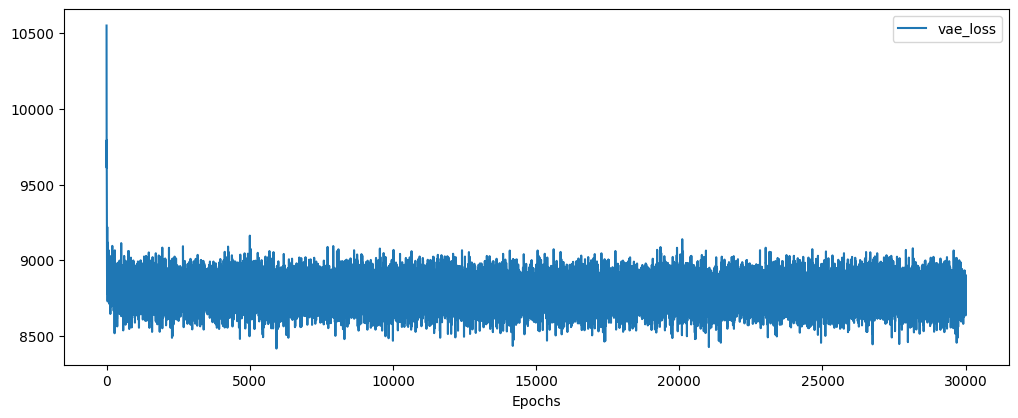

In [15]:
# Results Analyse
importlib.reload(ut)
ut.visualize.get_training_curves(history_frame=history_frame,
                                 metric = 'vae_loss',
                                 title=ittl,save_all_figs = True,results_path=results_path,
                                 destroy_fig=False)

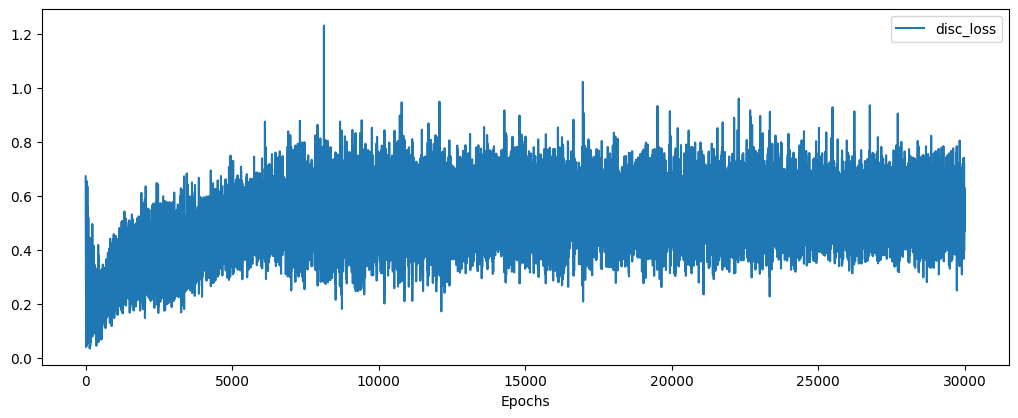

In [16]:
ut.visualize.get_training_curves(history_frame=history_frame,
                                metric = 'disc_loss',
                                 title=ittl,save_all_figs = True,results_path=results_path,
                                 destroy_fig=False)

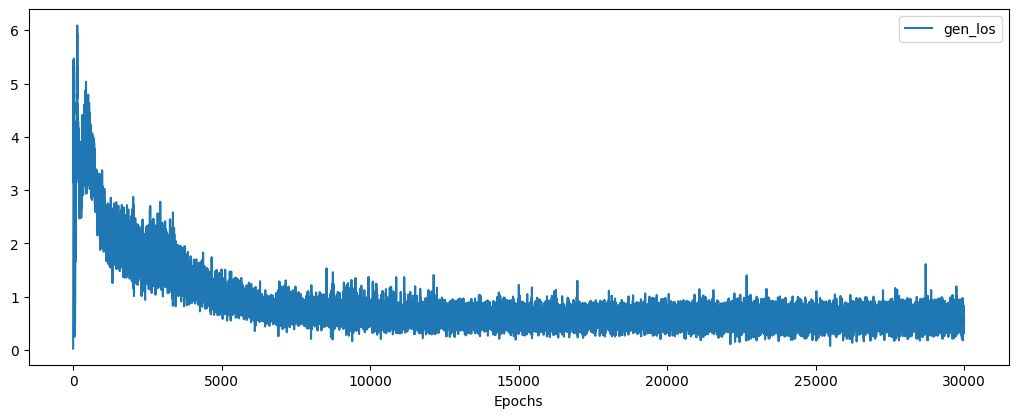

In [17]:
ut.visualize.get_training_curves(history_frame=history_frame,
                                 metric = 'gen_los',
                                 title=ittl,
                                 save_all_figs = True,results_path=results_path,
                                 destroy_fig=False)

In [18]:
explore_latent_space = True
if explore_latent_space:
    encoder = mdl.Model_VAE_GAN_functions.get_encoder(latent_dim=latent_dim,
                                                      image_size=image_size,
                                                      print_summary=False)
    importlib.reload(mdl)
    decoder = mdl.Model_VAE_GAN_functions.get_decoder(latent_dim=latent_dim,
                                                      print_summary=False)
    importlib.reload(mdl)
    discriminator = mdl.Model_VAE_GAN_functions.get_discriminator(shape=[128, 128,3],
                                                                  print_summary=False)

In [19]:
# Visualization of latent space
importlib.reload(ut)
if explore_latent_space:
    z_mean_train,z_log_var, z_train = encoder.predict(train_generator, batch_size=32)
    pca1,z_mean_train_trans = ut.visualize.train_pca_on_latent_space(data=z_mean_train,
                                                                  n_components=2)
    pca2,z_train_trans = ut.visualize.train_pca_on_latent_space(data=z_train,
                                                                  n_components=2)
    z_mean_test,z_log_var_test, z_test = encoder.predict(test_generator, batch_size=16)
    z_mean_test_trans = pca1.transform(z_mean_test)
    z_test_trans = pca2.transform(z_test)

5/5 [==============================] - 2s 322ms/step


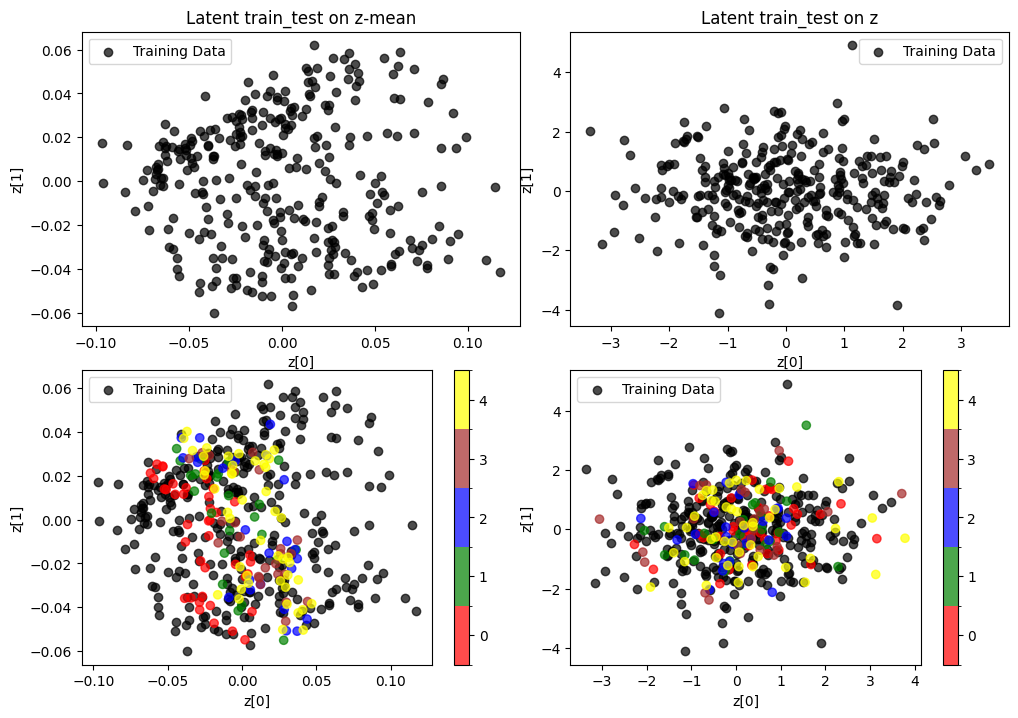

In [20]:
rows,cols = 2,2
fig,axs = plt.subplots(rows,cols,figsize=(10, 7)) #, sharey=True, sharex=True)
axs = axs.flatten()
y_test = test_generator.labels
z_val = [z_mean_train_trans,z_train_trans,z_mean_test_trans,z_test_trans]
bounds = np.arange(np.min(y_test) - 0.5, np.max(y_test) + 0.5, 1)
cmap = ListedColormap(['red', 'green', 'blue', 'brown','yellow'])
norm = BoundaryNorm(bounds, cmap.N)

for i in range(rows*cols):
    if i<2:
        c='black'
        ttl='train'
        im=axs[i].scatter(z_val[i][:, 0], z_val[i][:, 1], c=c,alpha=0.7, label='Training Data', cmap='tab10')
    else:
        c='black'
        ttl='train_test'
        if i==2:
            im=axs[i].scatter(z_val[0][:, 0], z_val[0][:, 1], c='black' ,alpha=0.7,label='Training Data')
        if i==3:
            im=axs[i].scatter(z_val[1][:, 0], z_val[1][:, 1], c='black' ,alpha=0.7,label='Training Data')
        im=axs[i].scatter(z_val[i][:, 0], z_val[i][:, 1], c=y_test , alpha=0.7,cmap=cmap, norm=norm)
        cbar = plt.colorbar(im)
        cbar.set_ticks(np.arange(0, np.max(test_generator.labels), 1))
    axs[i].legend()
    axs[i].set_xlabel  ("z[0]")
    axs[i].set_ylabel  ("z[1]")
    axs[0].set_title (f'Latent {ttl} on z-mean')
    axs[1].set_title (f'Latent {ttl} on z')
plt.subplots_adjust()
plt.tight_layout(pad=0.05)

plt.show()

(32, 128, 128, 3)


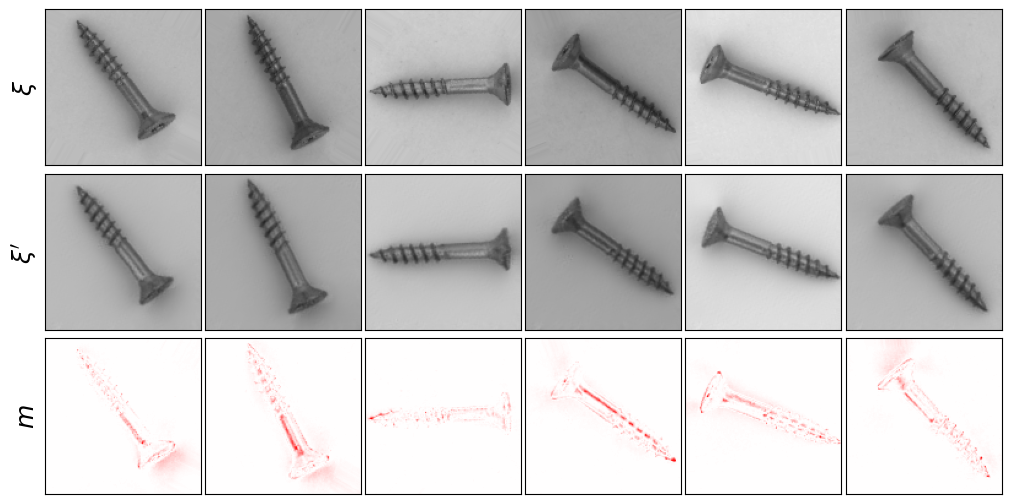

In [21]:
n = 6
importlib.reload(ut)
images = np.array(list(train_generator.next()))
print(images.shape)
fig, ax = plt.subplots(3, n, figsize=(10,5))
for ii in range(n):
    _, b_img = model.predict(np.array([images[ii]]), verbose=False)
    ax[0,ii].imshow(images[ii])
    ax[1,ii].imshow(b_img[0])
    diff_img = images[ii]- b_img[0]
    diff_img = np.linalg.norm(diff_img, axis=2)
    diff_img = np.square(diff_img)
    am_max = np.max(diff_img)
    ax[2,ii].imshow(diff_img, cmap='bwr', vmin=-am_max, vmax=am_max)
    for x in range(3):
        ax[x,ii].set_xticks([]) ; ax[x,ii].set_yticks([])
for i, label in enumerate([f'$\\xi$',f"$\\xi'$",f'$m$']):
    ax[i][0].set_ylabel(label, fontsize=18)
plt.savefig(f'{results_path}/samples_m_{DS_name}.png',dpi=dpi, transparent=False, bbox_inches='tight', pad_inches=0)
plt.tight_layout(pad=0.30)

### GroundTruth Availability

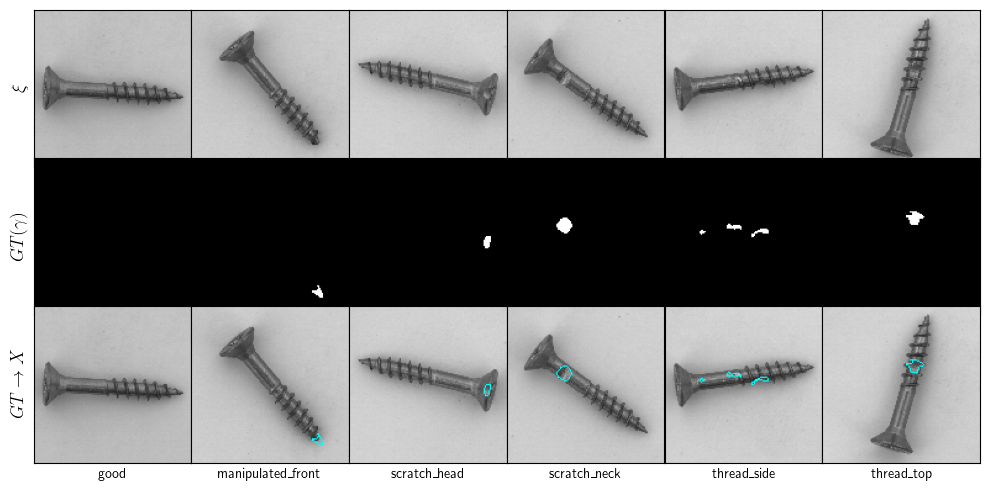

In [22]:
importlib.reload(ut)
plt.rc('text', usetex = True)
fig,axs = plt.subplots(3,len(anomaly_types), figsize=(10,5), sharex=True,sharey=True)

for a_type_id,a_type in enumerate(anomaly_types):
    I_A,gt = ut.Data.get_img_gt_by_index_class(anomaly_type=a_type,
                                               data_train=ds,
                                               data_test=ds_a,
                                               dataset=DS_name,
                                               data_gtruth=gt_a,
                                               image_no2=1)
    axs[0][a_type_id].imshow(I_A)
    axs[2][a_type_id].set_xlabel(f'{a_type}')
    axs[2][0].set_ylabel(f'$X (\\gamma)$ ',fontsize=12)    
    rgb_image = I_A
    binary_mask = gt[:,:,0].astype(np.uint8)
    axs[1][a_type_id].imshow(binary_mask, cmap='gray')  
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contoured_image = rgb_image.copy()
    cv2.drawContours(contoured_image, contours, -1, (0, 255, 255), 1)  # (0, 255, 255) corresponds to yellow, 2 is the thickness
    axs[2][a_type_id].imshow(contoured_image)
for ax in axs:
    for aa in ax:       
        aa.set_xticks([])
        aa.set_yticks([])
for i, lab in enumerate([f'$\\xi$',f"$GT(\\gamma)$",f'$GT \\rightarrow X$']):
    axs[i][0].set_ylabel(lab, fontsize=13)
plt.subplots_adjust(hspace=0)
plt.tight_layout(w_pad=0.01, h_pad=0.01)
plt.savefig(f'{results_path}/GT_{DS_name}.png',dpi=dpi, transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()

<h2 style='color:red'> Find Anomaly Scores for Whole Test Set</h2>

In [23]:
selector = 'max' # sum max
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_ds = { at : image_dataset_from_directory(test_dir+'/'+at, labels=None, label_mode = None,
                                         image_size=image_size, interpolation='nearest', 
                                         batch_size=64, shuffle=False)
           for at in anomaly_types }
anomaly_scores = []
test_images = [ np.array(list(test_ds[at].take(1))[0]) for at in anomaly_types ]
for i, at in enumerate(anomaly_types):
    z_mean, z_log_var, z = model.vae.encoder(test_images[i] / 255.0)
    reconstruction = model.vae.decoder(z_mean)
    if selector=='max':
        def get_anomaly_score(i, r):
            diff_norm = np.abs(r - i)
            return np.max(diff_norm)
    elif selector=='sum':
        def get_anomaly_score(i, r):
            diff_norm = np.abs(r - i)
            return np.sum(diff_norm)
    anomaly_scores.extend([(get_anomaly_score(reconstruction[j], test_images[i][j] / 255.0), 
                            at!='good', i, j,anomaly_types[i])  
                           for j in range(len(reconstruction))])
df_as = pd.DataFrame(anomaly_scores)
df_as.columns =['anomaly_score_new', 'good_or_bad','a_type_id','img_no','a_type' ]
df_as.head(5)

Found 41 files belonging to 1 classes.
Found 24 files belonging to 1 classes.
Found 24 files belonging to 1 classes.
Found 25 files belonging to 1 classes.
Found 23 files belonging to 1 classes.
Found 23 files belonging to 1 classes.


,anomaly_score_new,good_or_bad,a_type_id,img_no,a_type
0,0.272462,False,0,0,good
1,0.287328,False,0,1,good
2,0.440986,False,0,2,good
3,0.247188,False,0,3,good
4,0.253779,False,0,4,good


<h2 style='color:red'> FIND Delta Opt</h2>

In [24]:
importlib.reload(ut)
delta_opt = ut.Evaluate.find_optimal_separation_threshold(anomaly_scores)
print(f'delta_opt\t:\t{delta_opt}')

22 (0.31684425, False, 0, 22, 'good')
delta_opt	:	0.31685425473213197


<h2 style="color:red"> AD + XAI </h2>

#### Loss Fucntion for XAI METHODS

In [25]:
# From "General Frameworks for Anomaly Detection Explainability: A comparative study"
importlib.reload(ut)
from keras import backend as K
def mean_predict(model, data):
    z_mean, z_log_var, z = model.vae.encoder(data)
    reconstruction = model.vae.decoder(z_mean)
    return reconstruction
def lime_predict_loss(data, verbose=False):
    global model
    batch_size = K.shape(data)[0]
    reconstruction = mean_predict(model, data)
    MSE_loss = tf.reduce_sum(tf.square(reconstruction - data), axis=[1,2,3])
    return np.array([ [l] for l in MSE_loss ])

In [26]:
img = np.array([I_A])
print('lime_predict_loss\t\t',lime_predict_loss(img)[0][0])

lime_predict_loss		 30.720057


<h2 style="color:red"> SEGMENTATION FOR LIME </h2>

In [27]:
import skimage
from skimage.segmentation import quickshift
def get_segment_number(image, md):
    segments = quickshift(image, kernel_size=2, max_dist=md, ratio=0.95, rng=1234, sigma=0.05) 
    # segments = quickshift(image, kernel_size=2, max_dist=md, ratio=0.8, rng=1234, sigma=0.25) 
    return len(np.unique(segments)), segments

def search_segment_number(image, target_seg_no, init_max_dist=100):
    lmd, rmd = 0, init_max_dist
    lsn, _ = get_segment_number(image, lmd)
    rsn, _ = get_segment_number(image, rmd)
    niter = 0
    while niter<40 and rsn!=target_seg_no:
        niter += 1
        mmd = (lmd + rmd) / 2.0
        msn, _ = get_segment_number(image, mmd)
        if msn <= target_seg_no <= lsn:
            rsn, rmd = msn, mmd
        else:
            lsn, lmd = msn, mmd
    return get_segment_number(image, rmd) #rmd


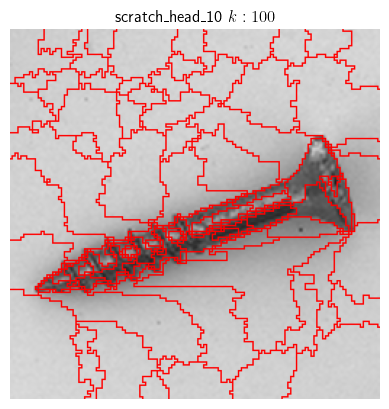

In [28]:
a_type = anomaly_types_gt[1]
image_no2 = 10
I_A,gt = ut.Data.get_img_gt_by_index_class(anomaly_type=a_type,
                                  data_train=ds,
                                  data_test=ds_a,
                                           dataset=DS_name,
                                  data_gtruth=gt_a,
                                  image_no2=image_no2)
I_A = I_A.astype(np.float32)
R_A = model.predict(np.array([I_A]), verbose=False)
R_A = R_A[1][0]
num_segments = 100
segs,segments = search_segment_number(R_A,target_seg_no=num_segments)
def segments_getter(img):
    return segments
    
immgg=skimage.segmentation.mark_boundaries(I_A, segments, 
                                           color=(1, 0, 0), outline_color=None, 
                                           mode='subpixel', background_label=0)
contoured_image = ut.Data.draw_gt_contour(grountruth_image=gt,
                                          input_image=immgg)
plt.imshow(immgg)
plt.title(f'{a_type}_{image_no2} $k: {segs}$')
plt.axis('off')
plt.savefig(f'{results_path}/segmentation_lime_{num_segments}.png',dpi=dpi, transparent=False, bbox_inches='tight', pad_inches=0)
plt.show()

<h2 style="color:red"> AD with LIME AND SHAP Single Example </h2>

k:100,num_sam:5000:   0%|          | 0/1 [00:00<?, ?it/s]

thread_top 3
pred_type by AS	:	 Anamolous 0.33428454


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]


PartitionExplainer explainer: 2it [00:22, 22.16s/it]                                                                                                                                                                               


1.9900222158541434
thread_top_3_blend_2


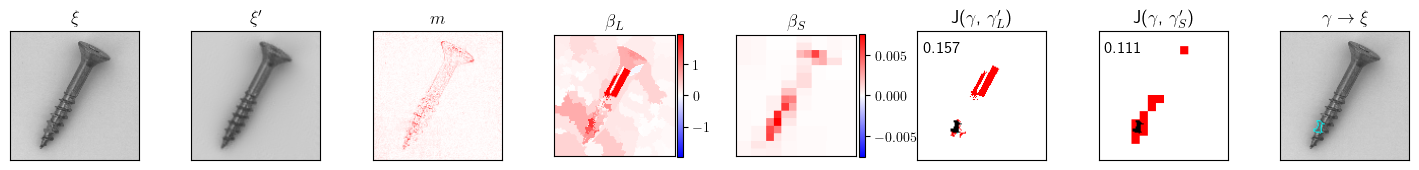

In [29]:
import time
import shap
from tqdm.notebook import tqdm
importlib.reload(ut)
score_functions     = [lime_predict_loss]
progress_bar_lime   = False
num_samples         = 5000
max_eval_shap       = 5000
# ['manipulated_front','scratch_head','scratch_neck', 'thread_side',  'thread_top']
anomaly_types_loop  = ['thread_top']
img_id              = 3
mask_types          = ['blend_2']
batch_size          = 200
batch_size_shap     = 200
target_segs         = 100
plt_add_type_img_id = False
a_type_shorten      = True
save_fig_lbls       = True
save_fig_by_parts   = False
save_all_subfigures = True

seg_types = ['quickshift' ]

ttl_score_functions = len(score_functions)
ttl_anomalies = len(anomaly_types)
ttl_comb = ttl_score_functions
plt.rc('text', usetex = True)
fig_rows = 1
fig_cols = ttl_comb+3+3
##### fig parameters  ##
fraction   = 0.048
shrink     = 1.0
pad        = 0.02
fontsize_sub = 24-fig_cols
########################
results_subs = os.path.join(results_path,'test_results')
expls = []
total_iterations = len(anomaly_types_loop) * len(score_functions)
pbar = tqdm(desc=f"k:{target_segs},num_sam:{num_samples}", total=total_iterations)
from lime.lime_image import LimeImageExplainer
for a_type_id,a_type in enumerate(anomaly_types_loop):
    time_start = time.time()
    results_subpath_cls = os.path.join(results_subs,str(a_type))
    results_subpath_cls_id = os.path.join(results_subpath_cls,str(img_id))
    if not os.path.exists(results_subpath_cls_id):
        os.makedirs(results_subpath_cls_id)
    print(a_type,img_id)
    asn = df_as[(df_as.a_type==f'{a_type}') & (df_as.img_no==img_id)].anomaly_score_new
    asn_bool = asn>delta_opt
    pred_type = 'Anamolous' if asn_bool.iloc[0] else 'Good'
    print('pred_type by AS\t:\t',pred_type,asn.iloc[0])
    
    I_A,gt = ut.Data.get_img_gt_by_index_class(anomaly_type=a_type,
                                               data_train=ds,
                                               data_test=ds_a,
                                               data_gtruth=gt_a,
                                               dataset=DS_name,
                                               image_no2=img_id)
    zIN_mean, zIN_logvar, zIN = np.array(model.vae.encoder(np.array([I_A])))[:,0,:]
    R_A = np.array(model.vae.decoder(np.array([zIN_mean]))[0])

    anomaly_map = np.max(np.abs(R_A-I_A), axis=2)
    am_max = np.max(anomaly_map)
    
    y_true_flat = (gt[:,:,0]!=0).flatten()
    predicted_flat  = np.linalg.norm(I_A - R_A, axis=2).flatten()
    contoured_image = ut.Data.draw_gt_contour(grountruth_image=gt,input_image=I_A)
    rgb_image = I_A
    binary_mask = gt[:,:,0].astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for seg_type_id,seg_type in enumerate(seg_types):
        for mask_type_id,mask_type in enumerate(mask_types):
            # print(mask_type_id,mask_type)
            if mask_type=='blend_2':
                mask = I_A*0.5+R_A*0.5
                mask_tp = f"x+x\'"
            elif mask_type=='blend_3':
                mask = I_A*0.33+R_A*0.33 + gt * 0.34
                mask_tp = f"x+x\'+gt"
            elif mask_type=='input':
                mask = I_A
                mask_tp = f"x+x\'+gt"
            elif mask_type=='reconstructed':
                mask = R_A
                mask_tp = f"x\'"
            mask_ttl = f'{mask_tp},k:{num_samples}'
            ###############################    SEGMENTATION     ###############################
            
            segs,segments = search_segment_number(mask,target_seg_no=target_segs)
            immgg=skimage.segmentation.mark_boundaries(I_A, segments,
                                                       color=(1, 0, 0), outline_color=None,
                                                       mode='subpixel', background_label=0)
            for score_function in score_functions:
                if save_fig_by_parts:
                    fig,axs = plt.subplots(1,3, figsize=(3,1))
                else:
                    fig,axs = plt.subplots(1,8, figsize=(14,2))
                score_function_name = f'{score_function.__name__}'
                score_function_name = score_function_name.replace('lime_predicter_', 'lm_p_')
                score_function_name = score_function_name.replace('lime_predict_', 'lm_p_')
                lime_explainer = LimeImageExplainer(random_state=1234)
                explanation = lime_explainer.explain_instance(I_A, score_function,
                                                                  labels = [a_type],
                                                                  segmentation_fn=segments_getter,
                                                                  hide_color=R_A,
                                                                  batch_size=batch_size,
                                                                  num_samples=num_samples)
                predicted_cls = explanation.top_labels[0]
                axs[0].imshow(I_A)
                axs[1].imshow(R_A)
                contoured_image = I_A.copy()
                cv2.drawContours(contoured_image, contours, -1, (0, 255, 255), 1)
                axs[2].imshow(anomaly_map, cmap='bwr', vmin=-am_max, vmax=am_max)
                if save_fig_by_parts:
                    for ax in axs.flatten():
                        ax.set_xticks([]) ; ax.set_yticks([])
                    plt.subplots_adjust(hspace=0.02)
                    plt.tight_layout(pad=0.03)
                    plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}_p1.svg',dpi=250, transparent=False)
                    plt.show()
                ##############################################################################
                if save_fig_by_parts:
                    fig,axs = plt.subplots(fig_rows,1, figsize=(3,1), squeeze=False)
                AM_roc_score    = 0.0 if a_type=='good' else sklearn.metrics.roc_auc_score(y_true_flat, predicted_flat)
            
                beta = ut.Explanation.get_beta_from_expl(explanation)
                cv_beta = ut.Explanation.get_CV_beta(beta)
                
                heatmap = ut.Explanation.heatmap_from_beta(segments,beta)
                heatmap_flat       = heatmap.flatten()
                Xx_lm, IoU_lm, threshold_lm = ut.visualize.calc_IoU_curve(y_true_flat, heatmap_flat)
                if save_fig_by_parts:
                    heat_lm_id = 0,0
                    
                else:
                    heat_lm_id = 3
                    shrink     = 1.0
                    pad        = 0.02
                    fraction   = 0.048
                
                maxval = np.max(np.abs(beta))
                heatmap_clr_bar= axs[heat_lm_id].imshow(heatmap, 
                                                           cmap='bwr',
                                                           vmin = -maxval, vmax = maxval)
                cbar = plt.colorbar(heatmap_clr_bar , pad=pad, orientation='vertical',
                                    fraction=fraction, shrink=shrink,
                                    ax=axs[heat_lm_id],
                                               )
                for t in cbar.ax.get_yticklabels():
                    t.set_fontsize(fontsize_sub-7)
                if save_fig_by_parts:
                    for ax in axs.flatten():
                        ax.set_xticks([]) ; ax.set_yticks([])
                    print(np.max(np.abs(beta)))
                    plt.subplots_adjust(hspace=0.05 , left=None, bottom=None, right=None , top=None, wspace=0.3)
                    # plt.tight_layout(pad=0.1)
                    plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}_p21.svg',
                                dpi=250, transparent=False, bbox_inches='tight', pad_inches=0)
                    plt.show()
                ############### SHAP ###################
                if mask_type=='blend_2' or len(mask_types)==1:
                    masker = shap.maskers.Image(R_A, R_A.shape)
                    explainer = shap.Explainer(score_function, masker, output_names=['Anomaly'])
                    shap_values = explainer(np.array([I_A]),
                                            max_evals=max_eval_shap,
                                            batch_size=batch_size_shap)
                    SI = np.array(shap_values.values)[0,:,:,0,0]
                    SI_flat = SI.flatten()
                    if save_fig_by_parts:
                        heat_sp_id = 0,0
                        fraction   = 0.048
                        shrink     = 1.0
                        pad = 0.02
                    else:
                        heat_sp_id = 4
                        fraction   = 0.048
                        shrink     = 1.0
                        pad        = 0.02
                    Xx_sp, IoU_sp, threshold_sp = ut.visualize.calc_IoU_curve(y_true_flat, SI_flat)
                ############################################
                if save_fig_by_parts:
                    fig,axs = plt.subplots(fig_rows,1, figsize=(3,1), squeeze=False)
                maxval = np.max(np.abs(SI))
                heatmap_clr_bar = axs[heat_sp_id].imshow(SI, cmap='bwr', vmin=-maxval, vmax=maxval)
                cbar = plt.colorbar(heatmap_clr_bar , pad=pad, orientation='vertical',
                                    fraction=fraction, shrink=shrink,ax=axs[heat_sp_id],
                                   )
                for t in cbar.ax.get_yticklabels():
                    t.set_fontsize(fontsize_sub-7)
                #####################################################################################
                
                for ax in axs.flatten():
                    ax.set_xticks([]) ; ax.set_yticks([])
                print(np.max(np.abs(beta)))
                plt.subplots_adjust(hspace=0.05 , left=None, bottom=None, right=None , top=None, wspace=0.3)
                    # plt.tight_layout(pad=0.1)
                if save_fig_by_parts:
                    plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}_p22.svg',
                                dpi=250, transparent=False, bbox_inches='tight', pad_inches=0)
                    plt.show()
                #####################################################################################
                # axs[5].imshow(np.max(gt.astype(float) / 256.0, axis=2), cmap='binary') 
                if save_fig_by_parts:
                    fig,axs = plt.subplots(1,3, figsize=(3,1))
                if save_fig_by_parts:
                    axs_p3 = 0
                else:
                    axs_p3 = 5
                axs[axs_p3].imshow(ut.visualize.combine_groundtruth_explanation(gt, heatmap, threshold_lm))
                axs[axs_p3].text(5,20, f'{np.max(IoU_lm):.3}', fontsize = 12)
                axs[axs_p3+1].imshow(ut.visualize.combine_groundtruth_explanation(gt, SI, threshold_sp))
                axs[axs_p3+1].text(5,20, f'{np.max(IoU_sp):.3}', fontsize = 12)
    
                contoured_image = I_A.copy()
                cv2.drawContours(contoured_image, contours, -1, (0, 255, 255), 1)  # (0, 255, 255) corresponds to yellow, 2 is the thickness               
                axs[axs_p3+2].imshow(contoured_image, aspect='equal')
                pbar.update(1)
                if plt_add_type_img_id:
                    axs[0].set_ylabel(f'{a_type}-{img_id}'    , fontsize=12)   
                else:
                    print(f'{a_type}_{img_id}_{mask_type}')
                for ax in axs.flatten():
                    ax.set_xticks([]) ; ax.set_yticks([])
                if save_fig_lbls:            
                    for i, lab in enumerate([f'$\\xi$',f"$\\xi\'$",f'$m$',f'$\\beta_L$',f'$\\beta_S$',f"J($\gamma$, $\gamma'_L$)",f"J($\gamma$, $\gamma'_S$)",f"$\\gamma\\rightarrow\\xi$" ]):
                        axs[i].set_title(lab, fontsize=13)
                for ax in axs.flatten():
                    ax.set_xticks([]) ; ax.set_yticks([])
                plt.subplots_adjust(hspace=0.02)
                plt.tight_layout(pad=0.03)
                if save_fig_by_parts:
                    plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}_p3.svg',dpi=250, transparent=False)
                    plt.show()
                else:
                    plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}.png',dpi=250)
                    plt.show()
                plt.show()

<h2 style='color:red'> Run XAI for Full Test Set.</h2>

In [ ]:
inspect_only        = False
target_segs         = 100
num_samples         = 5000
max_eval_shap       = 5000
batch_size          = 200
batch_size_shap     = 200
mask_types          = ['blend_2'] # 'blend_3'
save_fig_lbls       = True
compute_lime_shap   = 'both' # 'lime', 'shap'

if compute_lime_shap=='both':
    exp_methods = ['LIME_SHAP']
elif compute_lime_shap=='lime':
    exp_methods = ['LIME']
elif compute_lime_shap=='SHAP':
    exp_methods = ['SHAP']
if inspect_only:
    destroy_figs        = True
    save_figs           = False
    print_epochs        = True
else:
    destroy_figs        = True
    save_figs           = True
    print_epochs        = False
save_single_results = False
save_data           = True

test_images_try_ls = count_cls
save_txt            = False
print_summaries     = False
progress_bar_lime   = False
compute_time        = False
compute_ratio       = False
fontsize            = 10
plt.rcParams.update({'font.size': fontsize-3})
from datetime import datetime
importlib.reload(ut)
from tqdm.notebook import tqdm
from lime import lime_image
compute_full_data = True

############################################################
seg_types = ['quickshift' ]#,'slic','felzenszwalb']

score_functions = [lime_predict_loss]
ttl_score_functions = len(score_functions)
ttl_anomalies = len(anomaly_types)
sig_factors = [3]
use_stratifications = [False]
ttl_comb = ttl_score_functions*len(use_stratifications)    
############# Fixed Param ###############
a_types = []
results=[]
data={}
if compute_time:
  results_time=[]
  data_time={}

total_iterations = len(sig_factors)* len(score_functions) * len(seg_types) * len(mask_types)* len(use_stratifications) * np.sum(test_images_try_ls)

fig_rows = 1
fig_cols = ttl_comb+3+3
fontsize_sub = 24-fig_cols

pbar = tqdm(desc=f"k:{target_segs},num_sam:{num_samples}", total=total_iterations)
print('Trying total combinations \t: \t',total_iterations)

postfix_csv = f'{total_iterations}_{target_segs}_{epochs}_{num_samples}_{DS_name}_{mask_types[0]}'

results_subs = os.path.join(results_path,'test_results')
ut.Data.path_verifier(path=results_subs)
from time import time
now = datetime.now()
print("Example Started\t\t\t:\t", now.strftime("%d/%m/%Y %H:%M:%S"))
time_stamps = []
print('+'*120)
if print_epochs:
    print(f'Exp No\t\t|\t Classes \t|  \tImages\t|\t\t Title \t\t\t|')
curr_iteration = 0
curr_iteration_per_image=0
if print_summaries:
    print(f'Full Iterations\tClasses\t Images/Class \t Title\t\t\t|')
from lime.lime_image import LimeImageExplainer
lime_explainer = LimeImageExplainer(random_state=1234)
# ['manipulated_front','scratch_head','scratch_neck','thread_side','thread_top']
run_test_anomaly_types = 'anomalous' # all
if run_test_anomaly_types=='all':
    anom_type = anomaly_types
elif run_test_anomaly_types=='anomalous':
    anom_type = anomaly_types_gt
    test_images_try_ls = test_images_try_ls[1:]

for a_type_id,a_type in enumerate(anom_type):
    if a_type=='manipulated_front':
        a_type_lbl = 'manip. front'
    elif  a_type=='scratch_head':
        a_type_lbl = 'scr. head'
    elif  a_type=='scratch_neck':
        a_type_lbl = 'scr. neck'
    elif  a_type=='thread_side':
        a_type_lbl = 'thread sd.'
    elif  a_type=='thread_top':
        a_type_lbl = 'thread top'
        
    for img_id in range(test_images_try_ls[a_type_id]):
        results_subpath_cls = os.path.join(results_subs,str(a_type))
        if save_data:
            ut.Data.path_verifier(path=results_subpath_cls)
            results_subpath_cls_id = os.path.join(results_subpath_cls,str(img_id))
            ut.Data.path_verifier(path=results_subpath_cls_id)
          if save_txt:
            results_subpath_cls_id_aucroc = os.path.join(results_subpath_cls_id,'aucroc')
            ut.Data.path_verifier(path=results_subpath_cls_id_aucroc)
          if save_single_results:
            results_subpath_cls_id_single = os.path.join(results_subpath_cls_id,'single')
            ut.Data.path_verifier(path=results_subpath_cls_id_single)
        I_A,gt = ut.Data.get_img_gt_by_index_class(anomaly_type=a_type,
                                                   data_train=ds,
                                                   data_test=ds_a,
                                                   dataset=DS_name,
                                                   data_gtruth=gt_a,
                                                   image_no2=img_id)
        time_start = time()
        zIN_mean, zIN_logvar, zIN = np.array(model.vae.encoder(np.array([I_A])))[:,0,:]
        R_A = np.array(model.vae.decoder(np.array([zIN_mean]))[0])
        anomaly_map = np.max(np.abs(R_A-I_A), axis=2)
        am_max = np.max(anomaly_map)

        am_max1 = np.max(np.abs(R_A - I_A))
        time_pred = time() - time_start
        y_true_flat = (gt[:,:,0]!=0).flatten()
        predicted_flat  = np.linalg.norm(I_A - R_A, axis=2).flatten()
        
        AM_roc_score    = 0.0 if a_type=='good' else sklearn.metrics.roc_auc_score(y_true_flat, predicted_flat)
        AM_roc_score_sq   =0.0 if a_type=='good' else sklearn.metrics.roc_auc_score(y_true_flat, np.square(predicted_flat))
        fpr, tpr, _     = roc_curve(y_true_flat, predicted_flat)
        fpr_sq, tpr_sq, _     = roc_curve(y_true_flat, np.square(predicted_flat))
        time_start = time()
        contoured_image = I_A.copy()
        contoured_image = ut.Data.draw_gt_contour(grountruth_image=gt,
                                                  input_image=I_A)

        
        time_countourdraw = time() - time_start
        rgb_image = I_A
        binary_mask = gt[:,:,0].astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contoured_image, contours, -1, (0, 255, 255), 1)  # (0, 255, 255) corresponds to yellow, 2 is the thickness
        for seg_type_id,seg_type in enumerate(seg_types):
            for mask_type_id,mask_type in enumerate(mask_types):
                # print(mask_type_id,mask_type)
                if mask_type=='blend_2':
                    mask = I_A*0.5+R_A*0.5
                    mask_tp = f"x+x\'"
                elif mask_type=='blend_3':
                    mask = I_A*0.33+R_A*0.33 + gt * 0.34
                    mask_tp = f"x+x\'+gt"
                elif mask_type=='input':
                    mask = I_A
                    mask_tp = f"x+x\'+gt"
                elif mask_type=='reconstructed':
                    mask = R_A
                    mask_tp = f"x\'"
                mask_ttl = f'{mask_tp},k:{num_samples}'
                ###############################    SEGMENTATION     ###############################
                time_start = time()
                segs,segments = search_segment_number(mask,target_seg_no=target_segs)
                time_seg = time() - time_start
                immgg=skimage.segmentation.mark_boundaries(I_A, segments,
                                                           color=(1, 1, 0), outline_color=None,
                                                           mode='subpixel', background_label=0)
                fig,axs = plt.subplots(1,8, figsize=(14,2))
                axs[0].imshow(I_A)
                axs[1].imshow(R_A)
                ######################## ANOMALY MAP   ########################
                axs[2].imshow(anomaly_map, cmap='bwr', vmin=-am_max, vmax=am_max)
                ########################  Anomaly Score      ########################
                anomaly_score = ut.Evaluate.computer_anomaly_score(input_image=I_A,
                                                  reconstructed_image=R_A)
                counter = 0
                for score_function_id,score_function in enumerate(score_functions):
                    anomaly_score_val = score_function(np.array([I_A]))[0][0]
                    for us_id,us in enumerate(use_stratifications):
                        # print(f'ax{score_function_id+us_id}')
                        score_function_name = f'{score_function.__name__}'
                        score_function_name = score_function_name.replace('lime_predicter_', 'lm_p_')
                        score_function_name = score_function_name.replace('lime_predict_', 'lm_p_')
                        time_start = time()
                        explanation = lime_explainer.explain_instance(I_A, score_function,
                                                              labels = [a_type],
                                                              segmentation_fn=segments_getter,
                                                              hide_color=R_A,
                                                              batch_size=batch_size,
                                                              num_samples=num_samples)
                        predicted_cls = explanation.top_labels[0]
                        ######################################
                        time_lime = time() - time_start
                        beta = ut.Explanation.get_beta_from_expl(explanation)
                        heatmap = ut.Explanation.heatmap_from_beta(segments,beta)
                        #####################################
                        TL = explanation.top_labels[0]
                        cv_beta = ut.Explanation.get_CV_beta(beta)
                        sigma = np.std(beta)
                        maxval = np.max(np.abs(beta))
                        inc= 2
                        for sig_factor_id,sig_factor in enumerate(sig_factors):
                            ttl = f'{a_type}_{img_id}_{score_function_name}_{us}_{seg_type}_{target_segs}_{num_samples}_{sig_factor}_{epochs}'
                            sub_ttl = f'{score_function_name}_{seg_type}_{target_segs}_{num_samples}_{sig_factor}_{epochs}'
                            sub_ttl1 = f'{a_type}_{img_id}'
                            temp_1, mask_1 = explanation.get_image_and_mask(predicted_cls, positive_only=True,
                                                                min_weight=sigma*sig_factor,
                                                                 num_features=1000, hide_rest=False)
                            curr_iteration=curr_iteration+1
                        if print_epochs:
                            print(f'{str(curr_iteration)}/{str(total_iterations):5s} \t\t {str(a_type_id+1)}/{str(ttl_anomalies):5s}\t\t{str(img_id+1)}/{str(test_images_try_ls[a_type_id]):5s} \t {ttl:15s}')
                        heatmap_flat       = heatmap.flatten()
                        ttl_txt = f'{score_function_name}_{us}_{num_samples}_{sig_factor}_{epochs}_{target_segs}'
                        auroc       = 0.0 if a_type=='good' else sklearn.metrics.roc_auc_score(y_true_flat, heatmap_flat)
                        LIME_roc_abs_score    = 0.0 if a_type=='good' else sklearn.metrics.roc_auc_score(y_true_flat, np.abs(heatmap_flat))
                        heatmap_gs1 = gaussian_filter(heatmap, sigma=1)
                        heatmap_gs2 = gaussian_filter(heatmap, sigma=2)
                        auroc_gs1 = 0.0 if a_type=='good' else roc_auc_score(y_true_flat, heatmap_gs1.flatten())
                        auroc_gs2 = 0.0 if a_type=='good' else roc_auc_score(y_true_flat, heatmap_gs2.flatten())
                        #################################################################
                        Xx_lm, IoU_lm, threshold_lm = ut.visualize.calc_IoU_curve(y_true_flat, heatmap_flat)
                        #################################################################
                        fpr_h, tpr_h, _ = roc_curve(y_true_flat, heatmap_flat)
                        heat_lm_id = 3
                        heatmap_clr_bar= axs[heat_lm_id].imshow(heatmap, cmap='bwr',
                                                                 vmin = -maxval, 
                                                                 vmax = maxval)
                        cbar = plt.colorbar(heatmap_clr_bar , pad=0, orientation='vertical',
                                            fraction=0.048, shrink=0.8,ax=axs[heat_lm_id],
                                           )
                        for t in cbar.ax.get_yticklabels():
                             t.set_fontsize(fontsize_sub-7)
                        ttl_heatmap = 'St' if us else 'MC'
                        heat_ttl = f"$US$ | $auroc$ | $cv\_beta$ | $\\tau$ | $IoU$ \n${ttl_heatmap}|{auroc:0.2}|{cv_beta:0.2}|{threshold_lm:0.3}|{np.max(IoU_lm):0.3}$"

                        axs[5].imshow(ut.visualize.combine_groundtruth_explanation(gt, heatmap, threshold_lm))
                        axs[5].text(5,20, f'{np.max(IoU_lm):.3}', fontsize = 10)
                        ########################  SHAP     ########################
                        if mask_type=='blend_2':
                            masker = shap.maskers.Image(R_A, R_A.shape)
                            explainer = shap.Explainer(score_function,
                                                       masker, 
                                                       output_names=['Anomaly'])
                            shap_values = explainer(np.array([I_A]),
                                                    max_evals=max_eval_shap,
                                                    batch_size=batch_size_shap)
                            SI = np.array(shap_values.values)[0,:,:,0,0]
                            SI_flat = SI.flatten()   
                            maxval_sp = np.max(np.abs(SI))
                            Xx_sp, IoU_sp, threshold_sp = ut.visualize.calc_IoU_curve(y_true_flat, SI_flat)
                        axs[4].imshow(SI, cmap='bwr', vmin=-maxval_sp, vmax=maxval_sp)

                        heat_sp_id = 4
                        heatmap_clr_bar= axs[heat_sp_id].imshow(SI, cmap='bwr',
                                                                 vmin = -maxval_sp, 
                                                                 vmax = maxval_sp)
                        cbar = plt.colorbar(heatmap_clr_bar , pad=0, orientation='vertical',
                                            fraction=0.048, shrink=0.8,ax=axs[heat_sp_id],
                                           )
                        for t in cbar.ax.get_yticklabels():
                             t.set_fontsize(fontsize_sub-7)
                            
                        axs[6].imshow(ut.visualize.combine_groundtruth_explanation(gt, SI, threshold_sp))
                        axs[6].text(5,20, f'{np.max(IoU_sp):.3}', fontsize = 10)
                        axs[7].imshow(contoured_image, aspect='equal')
                        ########################
                        lime_mc     = auroc
                        lime_mc_gs1 = auroc_gs1
                        lime_mc_gs2 = auroc_gs2
                        lime_mc_abs = LIME_roc_abs_score
                        ########################
                        r = random.random() 
                        b = random.random() 
                        g = random.random() 
                        color = (r, g, b) 
                        # Plot the line in dark orange with the label "AS" only for the first plot
                        if not us:
                            axs[fig_cols-1].plot(fpr, tpr, color='darkorange', lw=1, label=f'AS = {AM_roc_score:.2f}')
                            axs[fig_cols-1].plot(fpr_sq, tpr_sq, color='darkred', lw=1, label=f'AS_sq = {AM_roc_score_sq:.2f}')
                        counter = counter + 1
                        axs[0].set_ylabel(f'{a_type_lbl} - {img_id}', fontsize=12)
                        # time_start_plot
                        pbar.update(1)
                        ############################ DATA   #####################################
                        data = {'exp_no':str(curr_iteration),
                                'a_type_id':a_type_id,
                                'a_type':a_type,
                                'img_no':img_id,
                                'seg_type':seg_type,
                                'mask_type':mask_type,
                                'target_segs':target_segs,
                                'segs':segs,
                                'use_stratification':us,
                                'epochs':epochs,
                                'num_samples':num_samples,
                                'sig_factor':sig_factor,
                                'sigma':sigma,
                                'score_function':score_function_name,
                                'cv_beta':cv_beta,
                                'heat_max':np.max(heatmap),
                                'beta_max':np.max(beta),
                                'threshold_lm':threshold_lm,
                                'IoU_lm_max':np.max(IoU_lm),
                                'IoU_lm_mean':np.mean(IoU_lm),
                                'IoU_lm_std':np.std(IoU_lm),
                                'heat_max':np.max(heatmap),
                                'IoU_sp_max':np.max(IoU_sp),
                                'IoU_sp_mean':np.mean(IoU_sp),
                                'IoU_sp_std':np.std(IoU_sp),
                                'threshold_sp':threshold_sp,
                                'anomaly_score':am_max,
                                'anomaly_score_val':anomaly_score_val,
                                'AM_roc_score':AM_roc_score,
                                'auroc':auroc,
                                'auroc_gs1':auroc_gs1,
                                'auroc_gs2':auroc_gs2,
                                'LIME_roc_abs':LIME_roc_abs_score
                                }
                        results.append(data)
                        df = pd.DataFrame(results)
                        df.to_csv(f'{results_path}/testresults_{postfix_csv}_{exp_methods}.csv', sep=',')
                    for ax in axs.flatten():
                        ax.set_xticks([]) ; ax.set_yticks([])
                    if compute_time:
                          time_plot = time() - time_start_plot
                          data_time = {'exp_no':str(curr_iteration),
                                       'a_type_id':a_type_id,
                                       'a_type':a_type,
                                       'img_no':img_id,
                                       'seg_type':seg_type,
                                       'mask_type':mask_type,
                                       'target_segs':target_segs,
                                       'segs':segs,
                                       'use_stratification':us,
                                       'epochs':epochs,
                                       'num_samples':num_samples,
                                       'sig_factor':sig_factor,
                                       'sigma':sigma,
                                       'score_function':score_function_name,
                                       'time_pred':time_pred,
                                       'time_seg':time_seg,
                                       'time_lime':time_lime,
                                       'time_plot':time_plot,
                                       'time_countourdraw':time_countourdraw}
                          results_time.append(data_time)
                    if save_fig_lbls:
                        for i, lab in enumerate([f'$\\xi$',f"$\\xi\'$",f'$m$',f'$\\beta_L$',f'$\\beta_S$',f"J($\gamma$, $\gamma'_L$)",f"J($\gamma$, $\gamma'_S$)",f"$\\gamma\\rightarrow\\xi$"]):
                            axs[i].set_title(lab, fontsize=15)
                plt.subplots_adjust(hspace=0.02)
                plt.tight_layout(pad=0.03)
                if save_figs:
                  plt.savefig(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}.png',dpi=250, transparent=False)
                if destroy_figs:
                  plt.close(fig)
                plt.show()
now = datetime.now()
print("Example Completed\t\t:\t\t\t", now.strftime("%d/%m/%Y %H:%M:%S"))
time_stamps.append(["Example_Completed", now.strftime("%d/%m/%Y %H:%M:%S")])

df = pd.DataFrame(results)
df.to_csv(f'{results_path}/testresults_{postfix_csv}_{exp_methods}.csv', sep=',')
#####################################   RATIO   #####################################
if compute_ratio:
  df_ratio = pd.DataFrame(results_ratio)
  df_ratio.to_csv(f'{results_path}/testratio_{postfix_csv}.csv', sep=',')
#####################################   TIME   #####################################
if compute_time:
  df_time = pd.DataFrame(time_stamps)
  df_time_single = pd.DataFrame(results_time)
  df_time_total = pd.DataFrame(time_stamps)
  df_time_single.to_csv(f'{results_path}/timeresults_single_{postfix_csv}.csv', sep=',')
  df_time_total.to_csv(f'{results_path}/timeresults_total{postfix_csv}.csv', sep=',')

<h2 style='color:red'> LOAD DATA FILE GENERATED BY STEP XXX.</h2>

In [30]:
file = "testresults_320_100_30000_5000_screw_blend_2_['LIME_SHAP'].csv"
df_loaded = pd.read_csv(f'{results_path}/{file}', sep=',')
df = df_loaded
print(len(df))
df.head(5)

320


,Unnamed: 0,exp_no,a_type_id,a_type,img_no,seg_type,mask_type,target_segs,segs,use_stratification,...,IoU_sp_mean,IoU_sp_std,threshold_sp,anomaly_score,anomaly_score_val,AM_roc_score,auroc,auroc_gs1,auroc_gs2,LIME_roc_abs
0,0,1,0,good,0,quickshift,blend_2,100,100,False,...,0.0,0.0,0.001702,0.272462,6.644440,0.0,0.0,0.0,0.0,0.0
1,1,2,0,good,0,quickshift,blend_3,100,100,False,...,0.0,0.0,0.001702,0.272462,6.644440,0.0,0.0,0.0,0.0,0.0
2,2,3,0,good,1,quickshift,blend_2,100,100,False,...,0.0,0.0,0.001550,0.287327,6.984655,0.0,0.0,0.0,0.0,0.0
3,3,4,0,good,1,quickshift,blend_3,100,100,False,...,0.0,0.0,0.001550,0.287327,6.984655,0.0,0.0,0.0,0.0,0.0
4,4,5,0,good,2,quickshift,blend_2,100,100,False,...,0.0,0.0,0.002581,0.440986,7.383140,0.0,0.0,0.0,0.0,0.0


In [31]:
good = df.sort_values('IoU_lm_max' , ascending=False)
bad = df.sort_values('AM_roc_score' , ascending=False)

df['as_by_iou_lm'] =  df.anomaly_score / df.IoU_lm_max
df['as_by_iou_sp'] =  df.anomaly_score / df.IoU_sp_max

df.sort_values('as_by_iou_lm' , ascending=True).head(5)

,Unnamed: 0,exp_no,a_type_id,a_type,img_no,seg_type,mask_type,target_segs,segs,use_stratification,...,threshold_sp,anomaly_score,anomaly_score_val,AM_roc_score,auroc,auroc_gs1,auroc_gs2,LIME_roc_abs,as_by_iou_lm,as_by_iou_sp
133,133,134,2,scratch_head,1,quickshift,blend_3,100,100,False,...,0.003172,0.275055,9.740903,0.948366,1.0,0.999997,0.999857,1.0,0.275055,0.905669
183,183,184,3,scratch_neck,2,quickshift,blend_3,100,100,False,...,0.003184,0.294216,9.264563,0.902250,1.0,0.998571,0.993093,1.0,0.294216,0.630463
239,239,240,4,thread_side,5,quickshift,blend_3,100,100,False,...,0.002892,0.312679,10.297098,0.901924,1.0,0.997989,0.990441,1.0,0.312679,0.736310
245,245,246,4,thread_side,8,quickshift,blend_3,100,100,False,...,0.004433,0.317575,9.084911,0.860515,1.0,0.983146,0.973109,1.0,0.317575,0.635149
283,283,284,5,thread_top,4,quickshift,blend_3,100,100,False,...,0.003404,0.317979,9.793831,0.927521,1.0,0.999964,0.999793,1.0,0.317979,0.755777


41 41
119 119


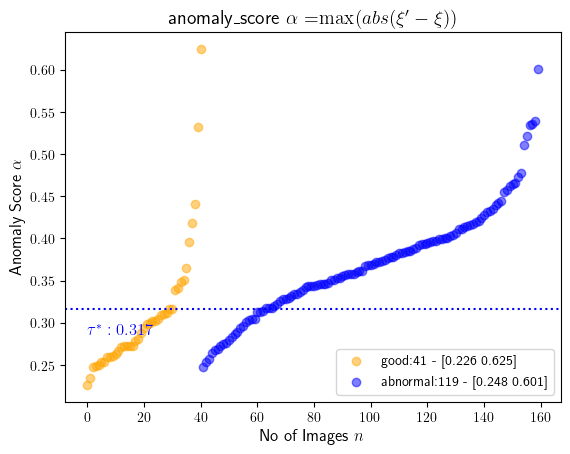

In [32]:
ttl = f"anomaly_score $\\alpha$ =$\{selector}(abs(\\xi\'-\\xi))$"
df_as = df_as.sort_values('anomaly_score_new', ascending=True)
good     = df_as[df_as['good_or_bad']==False].sort_values('anomaly_score_new', ascending=True).anomaly_score_new
abnormal = df_as[df_as['good_or_bad']==True].sort_values('anomaly_score_new', ascending=True).anomaly_score_new
X1 = range(0,41,1)
X2 = range(41,119+41,1)
print(len(good),len(X1))
print(len(abnormal),len(X2))
plt.scatter(X1,good, c= 'orange', alpha=0.5, label=f'good:{len(X1)} - [{np.min(good):0.3}~{np.max(good):0.3}]')
plt.scatter(X2,abnormal, c= 'blue', alpha=0.5, label=f'abnormal:{len(X2)} - [{np.min(abnormal):0.3}~{np.max(abnormal):0.3}]')
plt.axhline(delta_opt, ls = ':', color = 'blue')
plt.text(0.1,delta_opt-0.03,f'$\\tau^*:{delta_opt:0.3}$', color = 'blue', fontsize=12)
plt.title(ttl, fontsize=14)
plt.xlabel('No of Images $n$', fontsize=12)
plt.ylabel('Anomaly Score $\\alpha$', fontsize=12)
plt.legend(fontsize=10)
plt.subplots_adjust()
plt.savefig(f'{results_path}/anomaly_score_separation_{selector}.png', bbox_inches='tight', pad_inches=0)
plt.show()

<h2 style='color:red'> GENERATE HTML FILE USING IMAGES GENERATED BY STEP XXX.</h2>

In [33]:
target_segs = 100
mask_type = 'blend_2'
epochs= 30000
num_samples = 5000
lbls_cls = list(image_counter.keys())
count_cls = list(image_counter.values())
html_f_name = f'{results_path}/imgs_{DS_name}_full.html'
header = '<html><body>'
with open(html_f_name, 'w') as f:
    f.write(header)
with open(html_f_name, 'a') as f:
    f.write("<style>.dotg {height: 30px;width: 30px;background-color: #008000;border-radius: 50%;display: inline-block;} .dotr {height: 30px;width: 30px;background-color: #ff0000;border-radius: 50%;display: inline-block;} table.space {margin-top: 10px;padding-top: 10px;width: 100%;} table{border: 1px solid black;}, th{font-size: 2em},tr{font-size: 2em}, td {border: 2px solid black;}</style>")

for a_type_id,a_type in enumerate(anomaly_types):
    for img_id in range(image_counter[f'{anomaly_types[a_type_id]}']):
        # print(len(range(test_images_try_ls[a_type_id])))
        results_subpath_cls = os.path.join(results_subs,str(a_type))
        results_subpath_cls_id = os.path.join(results_subpath_cls,str(img_id))
        img_path = os.path.abspath(f'{results_subpath_cls_id}/{a_type}_{img_id}_{num_samples}_{ttl_comb}_{epochs}_{target_segs}_{mask_type}.png')
        asn = df_as[(df_as.a_type==f'{a_type}') & (df_as.img_no==img_id)].anomaly_score_new
        asn_bool = asn>delta_opt
        pred_type = 'Anamolous' if asn_bool.iloc[0] else 'Good'
        if a_type!='good' and asn_bool.iloc[0]:
            with open(html_f_name, 'a') as f:
                f.write(f"<img src='{img_path}' width='75%'> <figcaption style='font-size: 2em'> <span class='dotg'></span>&nbsp;{a_type}-{img_id}:&nbsp;&nbsp;{asn.iloc[0]:0.4} &nbsp;&nbsp; {asn_bool.iloc[0]}-{pred_type}</figcaption><br>")
        if a_type!='good' and asn_bool.iloc[0]==False:
            with open(html_f_name, 'a') as f:
                f.write(f"<img src='{img_path}' width='75%'> <figcaption style='font-size: 2em'> <span class='dotr'></span>&nbsp;{a_type}-{img_id}:&nbsp;&nbsp;{asn.iloc[0]:0.4} &nbsp;&nbsp; {asn_bool.iloc[0]}-{pred_type}</figcaption><br>")

with open(html_f_name, 'a') as f:
    f.write('</body></html>')
print('Data Written in File')

Data Written in File


In [34]:
results_subpath_cls_id

'C:\\Users\\XN2\\anomaly_detection_trust_case_study\\results\\screw\\test_results\\thread_top\\22'

<h2 style="color:red"> Figure 2(b) </h2>

scaling_needed?: False
mask_type:  blend_2
Total Good: 41
S1
good_ok: 31
good_misclassified: 10
Total Bad: 119
abnorm_ok: 97
abnorm_misclassified: 22
masking method:  S1
caption_lbl: (b)


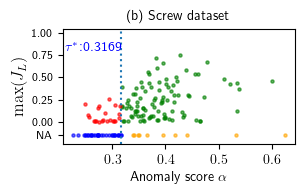

In [35]:
mask_type = 'blend_2'
iou_selected_tx  = 'lime' # 'shap'
if iou_selected_tx == 'lime':
    iou_selected  = f"IoU_lm_max"
    get_ylabel   = f"$\max(J_L)$"
else:
    iou_selected  = f"IoU_sp_max"
    get_ylabel   = f"$\max(J_S)$"

fig,ax = plt.subplots(1,1, figsize=(3,1.5))
df_ioU = df[['a_type', 'img_no','heat_max','IoU_lm_max','IoU_sp_max','threshold_lm','threshold_sp','mask_type']].copy()
df_ioU = df_ioU[df_ioU.mask_type==mask_type]
df_ioU.describe()
def int_to_float(value_int=False):
    return value_int/255.0 if value_int>1 else value_int
    
ds_thresh = delta_opt

both_df = df_ioU.merge(df_as, on=['img_no', 'a_type'])
scaling_needed = np.min(both_df.anomaly_score_new)>1

print('scaling_needed?:',scaling_needed)

both_df['as_by_ioumax'] = both_df.anomaly_score_new / both_df.eval(iou_selected)
df_count = pd.DataFrame()

both_df.sort_values('as_by_ioumax', ascending=False)
target_segs = np.unique(df.target_segs)[0]
epochs = np.unique(df.epochs)[0]
num_samples = np.unique(df.num_samples)[0]

low = 0.15
good_IoU_max = both_df[both_df.good_or_bad==False].eval(iou_selected)
bad_IoU_max = both_df[both_df.good_or_bad==True].eval(iou_selected)

df_count['dataset'] = [f'{DS_name}']
df_count['epochs'] = [f'{epochs}']
df_count['num_samples'] = [f'{num_samples}']

df_count['blend'] = mask_type
print('mask_type: ',mask_type)
df_count['threshold'] = ds_thresh
if iou_selected_tx == 'lime':
    if mask_type=='blend_2':
        blend_m = f'S1'
    elif mask_type=='blend_3':
        blend_m = f'S2'
else:
    blend_m = f'S3'
print('Total Good:',len(good_IoU_max))
print(blend_m)
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new<ds_thresh) & (both_df.mask_type ==mask_type)

anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low
ax.scatter(anomaly_score,max_iou, label=f'good/ok {len(both_df[sel])}', c='blue', alpha= 0.6, s=5)
print('good_ok:',len(both_df[sel]))
df_count['good_ok'] =  len(both_df[sel])
#####################
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new>ds_thresh)
anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low

ax.scatter(anomaly_score,max_iou, label=f'good/misclassified {len(both_df[sel])}',c='orange', alpha= 0.6, s=5)
print('good_misclassified:',len(both_df[sel]))

df_count['good_misclassified'] =  len(both_df[sel])
###################################
print('Total Bad:',len(bad_IoU_max))
##############################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new>ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/ok {len(both_df[sel])}', c='green', alpha= 0.6, s=5)
print('abnorm_ok:',len(both_df[sel]))
df_count['abnorm_ok'] =  len(both_df[sel])
########################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new<ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/misclassified {len(both_df[sel])}',c='red', alpha= 0.6, s=5)
print('abnorm_misclassified:',len(both_df[sel]))
df_count['abnorm_misclassified'] =  len(both_df[sel])
#############################################
ax.set_yticks([-low,0,0.25,0.50,0.75,1.00])
ax.set_yticklabels(['NA','0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)
ax.set_ylim(-0.25,1.05)
# ax.set_xticklabels(['0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)

if blend_m is not None:
    if DS_name=='hazelnut' and blend_m=='S1':
        caption_lbl = '(a)' 
    elif DS_name=='screw' and blend_m=='S1':
        caption_lbl = '(b)' 
    elif DS_name=='hazelnut' and blend_m=='S2':
        caption_lbl = '(c)'
    elif DS_name=='screw' and blend_m=='S2':
        caption_lbl = '(d)'
    elif DS_name=='hazelnut' and blend_m=='S3':
        caption_lbl = '(e)' 
    elif DS_name=='screw' and blend_m=='S3':
        caption_lbl = '(f)' 
    ax.set_ylabel(get_ylabel , fontsize = 12),
ax.axvline(ds_thresh, ls = ':')
plt.text(0.21,1-0.2,f'$\\tau^*$:{ds_thresh:0.4}' ,color='blue',fontsize=10)
# ax.axhline(np.min(both_df[both_df.good_or_bad==True].eval(iou_selected)), ls = ':')
ax.set_xlabel('Anomaly score $\\alpha$' , fontsize = 10),
ax.set_title(f'{caption_lbl} {string.capwords(DS_name)} dataset' , fontsize = 10)
plt.subplots_adjust()
ttl_str = f'{results_path}/plt_{DS_name}_{iou_selected_tx}_{blend_m}'
plt.savefig(f'{ttl_str}.pdf', bbox_inches='tight', transparent="True", pad_inches=0)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=2)

print('masking method: ',blend_m)
print('caption_lbl:',caption_lbl)

plt.show()

In [36]:
both_df = both_df[both_df.good_or_bad==False].sort_values('as_by_ioumax', ascending=True)

both_df['ratio_lm_sp'] = both_df.IoU_lm_max/both_df.IoU_sp_max
both_df.sort_values('ratio_lm_sp', ascending=False).head(5)

,a_type,img_no,heat_max,IoU_lm_max,IoU_sp_max,threshold_lm,threshold_sp,mask_type,anomaly_score_new,good_or_bad,a_type_id,as_by_ioumax,ratio_lm_sp
0,good,0,0.510575,0.0,0.0,0.510575,0.001702,blend_2,0.272462,False,0,inf,NaN
22,good,22,0.784346,0.0,0.0,0.784346,0.002614,blend_2,0.316844,False,0,inf,NaN
23,good,23,0.440585,0.0,0.0,0.440585,0.001957,blend_2,0.348764,False,0,inf,NaN
24,good,24,0.630705,0.0,0.0,0.630705,0.002436,blend_2,0.250086,False,0,inf,NaN
25,good,25,0.399250,0.0,0.0,0.399250,0.001829,blend_2,0.259378,False,0,inf,NaN


<h2 style="color:red"> Figure 2(d) </h2>

scaling_needed?: False
mask_type:  blend_3
Total Good: 41
S2
good_ok: 31
good_misclassified: 10
Total Bad: 119
abnorm_ok: 97
abnorm_misclassified: 22
masking method:  S2
caption_lbl: (d)


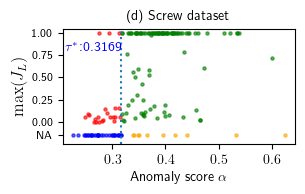

In [37]:
mask_type = 'blend_3'
iou_selected_tx  = 'lime' # 'shap'
if iou_selected_tx == 'lime':
    iou_selected  = f"IoU_lm_max"
    get_ylabel   = f"$\max(J_L)$"
else:
    iou_selected  = f"IoU_sp_max"
    get_ylabel   = f"$\max(J_S)$"

fig,ax = plt.subplots(1,1, figsize=(3,1.5))
df_ioU = df[['a_type', 'img_no','heat_max','IoU_lm_max','IoU_sp_max','threshold_lm','threshold_sp','mask_type']].copy()
df_ioU = df_ioU[df_ioU.mask_type==mask_type]
df_ioU.describe()
def int_to_float(value_int=False):
    return value_int/255.0 if value_int>1 else value_int
    
ds_thresh = delta_opt

both_df = df_ioU.merge(df_as, on=['img_no', 'a_type'])
scaling_needed = np.min(both_df.anomaly_score_new)>1

print('scaling_needed?:',scaling_needed)

both_df['as_by_ioumax'] = both_df.anomaly_score_new / both_df.eval(iou_selected)
df_count = pd.DataFrame()

both_df.sort_values('as_by_ioumax', ascending=False)
target_segs = np.unique(df.target_segs)[0]
epochs = np.unique(df.epochs)[0]
num_samples = np.unique(df.num_samples)[0]

low = 0.15
good_IoU_max = both_df[both_df.good_or_bad==False].eval(iou_selected)
bad_IoU_max = both_df[both_df.good_or_bad==True].eval(iou_selected)

df_count['dataset'] = [f'{DS_name}']
df_count['epochs'] = [f'{epochs}']
df_count['num_samples'] = [f'{num_samples}']

df_count['blend'] = mask_type
print('mask_type: ',mask_type)
df_count['threshold'] = ds_thresh
if iou_selected_tx == 'lime':
    if mask_type=='blend_2':
        blend_m = f'S1'
    elif mask_type=='blend_3':
        blend_m = f'S2'
else:
    blend_m = f'S3'
print('Total Good:',len(good_IoU_max))
print(blend_m)
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new<ds_thresh) & (both_df.mask_type ==mask_type)

anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low
ax.scatter(anomaly_score,max_iou, label=f'good/ok {len(both_df[sel])}', c='blue', alpha= 0.6, s=5)
print('good_ok:',len(both_df[sel]))
df_count['good_ok'] =  len(both_df[sel])
#####################
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new>ds_thresh)
anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low

ax.scatter(anomaly_score,max_iou, label=f'good/misclassified {len(both_df[sel])}',c='orange', alpha= 0.6, s=5)
print('good_misclassified:',len(both_df[sel]))

df_count['good_misclassified'] =  len(both_df[sel])
###################################
print('Total Bad:',len(bad_IoU_max))
##############################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new>ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/ok {len(both_df[sel])}', c='green', alpha= 0.6, s=5)
print('abnorm_ok:',len(both_df[sel]))
df_count['abnorm_ok'] =  len(both_df[sel])
########################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new<ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/misclassified {len(both_df[sel])}',c='red', alpha= 0.6, s=5)
print('abnorm_misclassified:',len(both_df[sel]))
df_count['abnorm_misclassified'] =  len(both_df[sel])
#############################################
ax.set_yticks([-low,0,0.25,0.50,0.75,1.00])
ax.set_yticklabels(['NA','0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)
ax.set_ylim(-0.25,1.05)
# ax.set_xticklabels(['0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)

if blend_m is not None:
    if DS_name=='hazelnut' and blend_m=='S1':
        caption_lbl = '(a)' 
    elif DS_name=='screw' and blend_m=='S1':
        caption_lbl = '(b)' 
    elif DS_name=='hazelnut' and blend_m=='S2':
        caption_lbl = '(c)'
    elif DS_name=='screw' and blend_m=='S2':
        caption_lbl = '(d)'
    elif DS_name=='hazelnut' and blend_m=='S3':
        caption_lbl = '(e)' 
    elif DS_name=='screw' and blend_m=='S3':
        caption_lbl = '(f)' 
    ax.set_ylabel(get_ylabel , fontsize = 12),
ax.axvline(ds_thresh, ls = ':')
plt.text(0.21,1-0.2,f'$\\tau^*$:{ds_thresh:0.4}' ,color='blue',fontsize=10)
# ax.axhline(np.min(both_df[both_df.good_or_bad==True].eval(iou_selected)), ls = ':')
ax.set_xlabel('Anomaly score $\\alpha$' , fontsize = 10),
ax.set_title(f'{caption_lbl} {string.capwords(DS_name)} dataset' , fontsize = 10)
plt.subplots_adjust()
ttl_str = f'{results_path}/plt_{DS_name}_{iou_selected_tx}_{blend_m}'
plt.savefig(f'{ttl_str}.pdf', bbox_inches='tight', transparent="True", pad_inches=0)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=2)

print('masking method: ',blend_m)
print('caption_lbl:',caption_lbl)

plt.show()

<h2 style="color:red"> Figure 2(f) </h2>

scaling_needed?: False
mask_type:  blend_2
Total Good: 41
S3
good_ok: 31
good_misclassified: 10
Total Bad: 119
abnorm_ok: 97
abnorm_misclassified: 22
masking method:  S3
caption_lbl: (f)


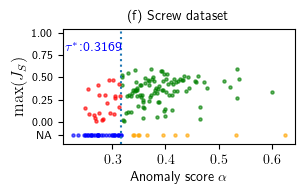

In [38]:
mask_type = 'blend_2'
iou_selected_tx  = 'shap' # 'shap'
if iou_selected_tx == 'lime':
    iou_selected  = f"IoU_lm_max"
    get_ylabel   = f"$\max(J_L)$"
else:
    iou_selected  = f"IoU_sp_max"
    get_ylabel   = f"$\max(J_S)$"

fig,ax = plt.subplots(1,1, figsize=(3,1.5))
df_ioU = df[['a_type', 'img_no','heat_max','IoU_lm_max','IoU_sp_max','threshold_lm','threshold_sp','mask_type']].copy()
df_ioU = df_ioU[df_ioU.mask_type==mask_type]
df_ioU.describe()
def int_to_float(value_int=False):
    return value_int/255.0 if value_int>1 else value_int
    
ds_thresh = delta_opt

both_df = df_ioU.merge(df_as, on=['img_no', 'a_type'])
scaling_needed = np.min(both_df.anomaly_score_new)>1

print('scaling_needed?:',scaling_needed)

both_df['as_by_ioumax'] = both_df.anomaly_score_new / both_df.eval(iou_selected)
df_count = pd.DataFrame()

both_df.sort_values('as_by_ioumax', ascending=False)
target_segs = np.unique(df.target_segs)[0]
epochs = np.unique(df.epochs)[0]
num_samples = np.unique(df.num_samples)[0]

low = 0.15
good_IoU_max = both_df[both_df.good_or_bad==False].eval(iou_selected)
bad_IoU_max = both_df[both_df.good_or_bad==True].eval(iou_selected)

df_count['dataset'] = [f'{DS_name}']
df_count['epochs'] = [f'{epochs}']
df_count['num_samples'] = [f'{num_samples}']

df_count['blend'] = mask_type
print('mask_type: ',mask_type)
df_count['threshold'] = ds_thresh
if iou_selected_tx == 'lime':
    if mask_type=='blend_2':
        blend_m = f'S1'
    elif mask_type=='blend_3':
        blend_m = f'S2'
else:
    blend_m = f'S3'
print('Total Good:',len(good_IoU_max))
print(blend_m)
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new<ds_thresh) & (both_df.mask_type ==mask_type)

anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low
ax.scatter(anomaly_score,max_iou, label=f'good/ok {len(both_df[sel])}', c='blue', alpha= 0.6, s=5)
print('good_ok:',len(both_df[sel]))
df_count['good_ok'] =  len(both_df[sel])
#####################
sel = (both_df.good_or_bad==False) & (both_df.anomaly_score_new>ds_thresh)
anomaly_score =both_df[sel].anomaly_score_new
max_iou  = both_df[sel].eval(iou_selected)-low

ax.scatter(anomaly_score,max_iou, label=f'good/misclassified {len(both_df[sel])}',c='orange', alpha= 0.6, s=5)
print('good_misclassified:',len(both_df[sel]))

df_count['good_misclassified'] =  len(both_df[sel])
###################################
print('Total Bad:',len(bad_IoU_max))
##############################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new>ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/ok {len(both_df[sel])}', c='green', alpha= 0.6, s=5)
print('abnorm_ok:',len(both_df[sel]))
df_count['abnorm_ok'] =  len(both_df[sel])
########################
sel = (both_df.good_or_bad==True) & (both_df.anomaly_score_new<ds_thresh)
ax.scatter(both_df[sel].anomaly_score_new,both_df[sel].eval(iou_selected), label=f'abnorm/misclassified {len(both_df[sel])}',c='red', alpha= 0.6, s=5)
print('abnorm_misclassified:',len(both_df[sel]))
df_count['abnorm_misclassified'] =  len(both_df[sel])
#############################################
ax.set_yticks([-low,0,0.25,0.50,0.75,1.00])
ax.set_yticklabels(['NA','0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)
ax.set_ylim(-0.25,1.05)
# ax.set_xticklabels(['0.00','0.25','0.50','0.75','1.00'] , fontsize = 8)

if blend_m is not None:
    if DS_name=='hazelnut' and blend_m=='S1':
        caption_lbl = '(a)' 
    elif DS_name=='screw' and blend_m=='S1':
        caption_lbl = '(b)' 
    elif DS_name=='hazelnut' and blend_m=='S2':
        caption_lbl = '(c)'
    elif DS_name=='screw' and blend_m=='S2':
        caption_lbl = '(d)'
    elif DS_name=='hazelnut' and blend_m=='S3':
        caption_lbl = '(e)' 
    elif DS_name=='screw' and blend_m=='S3':
        caption_lbl = '(f)' 
    ax.set_ylabel(get_ylabel , fontsize = 12),
ax.axvline(ds_thresh, ls = ':')
plt.text(0.21,1-0.2,f'$\\tau^*$:{ds_thresh:0.4}' ,color='blue',fontsize=10)
# ax.axhline(np.min(both_df[both_df.good_or_bad==True].eval(iou_selected)), ls = ':')
ax.set_xlabel('Anomaly score $\\alpha$' , fontsize = 10),
ax.set_title(f'{caption_lbl} {string.capwords(DS_name)} dataset' , fontsize = 10)
plt.subplots_adjust()
ttl_str = f'{results_path}/plt_{DS_name}_{iou_selected_tx}_{blend_m}'
plt.savefig(f'{ttl_str}.pdf', bbox_inches='tight', transparent="True", pad_inches=0)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=2)

print('masking method: ',blend_m)
print('caption_lbl:',caption_lbl)

plt.show()